In [1]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *


import scanpy as sc
import bbknn

In [2]:
#load the single cell atlas

In [3]:
#here use the Amrute et al (Nature 2024) 

adata = adata = sc.read('/data/norman/southark/external_datasets/fibro_atlas_cardiac_nature_2024/seurat_to_matrix/fibroblast_atlas_scored.h5ad')


In [4]:
adata 

AnnData object with n_obs × n_vars = 34910 × 22516
    obs: 'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'propmt', 'rna_size', 'ngene', 'prot_size', 'bc', 'droplet_class', 'nCount_ADT', 'nFeature_ADT', 'nCount_CITE', 'nFeature_CITE', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'CITE.weight', 'sct.dsb_snn_res.0.1', 'sct.dsb_snn_res.0.2', 'sct.dsb_snn_res.0.3', 'sct.dsb_snn_res.0.4', 'sct.dsb_snn_res.0.5', 'sct.dsb_snn_res.0.6', 'sct.dsb_snn_res.0.7', 'sct.dsb_snn_res.0.8', 'seurat_clusters', 'annotation.0.1', 'celltype', 'Sample.name', 'Date.of.harvest', 'HF.etiology', 'Txp.LVAD', 'Race', 'Sex', 'Age', 'time.since.last.ischemic.event', 'BMI', 'HTN', 'DM', 'MI', 'Stent', 'CABG', 'CKD', 'Smoker', 'EF', 'CO', 'Intermacs..profile.1....profile.2...2..profile.3.3..profile.4.4..profile.5.5.', 'Atrial.arrh', 'Ventricular.arrh', 'MR', 'MS', 'AR', 'AS', 'Pacemaker', 'ICD', 'Temp.mech.support..pre.op.', 'Durable.mech.support..pre.op', 'GDMT', 'Inotropes', 'SCT_snn_res.0.1', 'SCT_snn_res.0

In [5]:
data_path = '/data/norman/southark/tfs_standardized/'

guide_library = pd.read_csv(f'{data_path}20240410_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef_wGuide_labels.csv',
                           index_col = 0)

not_bad_seed = guide_library.query("~(bad_seed|seed_driven_fibro)").index

mean_pop = CellPopulation.from_hdf(f'{data_path}20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
mean_pop.genes.index.name = 'gene_id'

expanded_guides = guide_library.expanded_masked_active
mean_pop.cells['expanded_masked_active'] = expanded_guides
mean_pop.cells['masked_active'].fillna(False, inplace=True)
mean_pop.cells['expanded_masked_active'].fillna(False, inplace=True)

# various subsets of guides
masked_and_strongest = guide_library.query('masked_active and not bad_seed').sort_values('de_genes', ascending=False).groupby('target_gene').head(1).index
expanded_masked = guide_library.query('expanded_masked_active and not bad_seed').index

mean_pop.cells['primary_guide'] = mean_pop.cells.index.isin(masked_and_strongest)
mean_pop.cells['expanded_primary_guide'] = mean_pop.cells.index.isin(np.union1d(masked_and_strongest, expanded_masked))

#all clustered guides
all_clustered = mean_pop.cells.query('masked_active or expanded_masked_active').index
#all clustered guides
all_not_bad = mean_pop.cells[mean_pop.cells.index.isin(not_bad_seed)].index

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 5.596372365951538s.
Done.


/tmp/ipykernel_277888/62851403.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mean_pop.cells['masked_active'].fillna(False, inplace=True)
/tmp/ipykernel_277888/62851403.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [6]:
#comps: i.e. definitions of the sparse gene expression programs (positive if a gene is included)
comps = pd.read_csv(f'{data_path}20240331_fibroblast_bulk_comps.csv', index_col=0)

In [7]:
#subset (masked active?)
codes = pd.read_csv(f'{data_path}20240331_fibroblast_bulk_codes.csv', index_col=0)
codes.columns = codes.columns.astype(int)

#all guides
total_codes = pd.read_csv(f'{data_path}20240331_total_fibroblast_bulk_codes.csv', index_col=0)
total_codes.columns = total_codes.columns.astype(int)

In [8]:
expression_program_name = 31# Replace with the actual program name
guide_subset =all_clustered

# Step 2: Find the outlier columns for that expression program
feature_values = total_codes.loc[guide_subset, expression_program_name]
outlier_threshold_high = feature_values.quantile(0.98)  # Adjust these thresholds as needed
outlier_threshold_low = feature_values.quantile(0.02)
outlier_perturbations_high = feature_values[(feature_values > outlier_threshold_high)].index.tolist()
outlier_perturbations_low = feature_values.loc[(feature_values < outlier_threshold_low)].index.tolist()

In [9]:
pro_universal_tfs = set([g.split('_')[0] for g in outlier_perturbations_high])

In [10]:
anti_universal_tfs = set([g.split('_')[0] for g in outlier_perturbations_low])

In [11]:
sc.tl.score_genes(adata, pro_universal_tfs, score_name='universal_tf_score', use_raw = False)

In [12]:
pro_universal_tfs

{'BARX1',
 'CDX2',
 'FLI1',
 'FOXD2',
 'FOXP4',
 'GSX2',
 'HHEX',
 'KLF2',
 'KLF5',
 'SOX18'}

In [13]:
#recover back to raw data?

In [14]:
new_adata = sc.AnnData(X=adata.raw.X.copy(), 
                      var=adata.raw.var.copy(), 
                      obs=adata.obs.copy())
adata = new_adata

In [15]:
# 1. Normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=8000)

#Subset to HVGs and perform combat
adata = adata[:, adata.var.highly_variable]

In [17]:
adata.obs[['sample', 'Sample.name', 'Date.of.harvest', 'MI', 'HF.etiology',
'Txp.LVAD',
'Race',
'Sex',
'Age',
'time.since.last.ischemic.event',
'BMI',
'HTN',
'DM',
'Stent',
'CABG',
'CKD']].drop_duplicates(ignore_index = True)

,sample,Sample.name,Date.of.harvest,MI,HF.etiology,Txp.LVAD,Race,Sex,Age,time.since.last.ischemic.event,BMI,HTN,DM,Stent,CABG,CKD
0,sample13,Donor,11/11/20,0,Donor,Exp,AA,M,56,NaN,27.6700,1,1,0,0,0
1,sample28,D230121,1/23/21,1,ICM,Exp,White,F,41,4 mo,29.2100,1,1,1,0,1
2,sample32,D260521,3/19/21,0,Donor,Exp,White,F,38,NaN,29.1600,0,0,0,0,0
3,sample33,D190521,5/19/21,0,Donor,Exp,AA,F,53,NaN,23.0800,0,0,0,0,1
4,sample34,D210609,6/9/21,0,Donor,Exp,AA,F,54,NaN,51.5700,1,1,0,0,0
5,sample39,D1118,7/7/21,0,Donor,Exp,W,F,65,NaN,37.7800,0,1,0,0,0
6,sample41,D1119,7/7/21,0,Donor,Exp,AA,M,62,NaN,26.1600,1,0,0,0,0
7,sample4,V1030,7/24/20,1,AMI,LVAD,White,M,69,4 days,23.3600,0,0,1,0,1
8,sample5,V1041,8/26/20,1,AMI,LVAD,White,M,62,2 mo,27.3800,1,0,1,1,1
9,sample8,V1047,9/17/20,1,AMI,LVAD,White,M,64,3 mo,25.5900,1,1,1,0,1


In [18]:
sc.pp.combat(adata, key='sample')

/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:351: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [19]:
adata

View of AnnData object with n_obs × n_vars = 34910 × 8000
    obs: 'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'propmt', 'rna_size', 'ngene', 'prot_size', 'bc', 'droplet_class', 'nCount_ADT', 'nFeature_ADT', 'nCount_CITE', 'nFeature_CITE', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'CITE.weight', 'sct.dsb_snn_res.0.1', 'sct.dsb_snn_res.0.2', 'sct.dsb_snn_res.0.3', 'sct.dsb_snn_res.0.4', 'sct.dsb_snn_res.0.5', 'sct.dsb_snn_res.0.6', 'sct.dsb_snn_res.0.7', 'sct.dsb_snn_res.0.8', 'seurat_clusters', 'annotation.0.1', 'celltype', 'Sample.name', 'Date.of.harvest', 'HF.etiology', 'Txp.LVAD', 'Race', 'Sex', 'Age', 'time.since.last.ischemic.event', 'BMI', 'HTN', 'DM', 'MI', 'Stent', 'CABG', 'CKD', 'Smoker', 'EF', 'CO', 'Intermacs..profile.1....profile.2...2..profile.3.3..profile.4.4..profile.5.5.', 'Atrial.arrh', 'Ventricular.arrh', 'MR', 'MS', 'AR', 'AS', 'Pacemaker', 'ICD', 'Temp.mech.support..pre.op.', 'Durable.mech.support..pre.op', 'GDMT', 'Inotropes', 'SCT_snn_res.0.1', 'SCT_sn

In [20]:
from sklearn.cluster import KMeans


sc.tl.pca(adata)
n_clusters = 1500
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
adata.obs['kmeans_cluster'] = kmeans.fit_predict(adata.obsm['X_pca'])

/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [21]:
print(adata.obs['kmeans_cluster'].value_counts().describe())

count   1500.0000
mean      23.2733
std       11.7852
min        1.0000
25%       14.7500
50%       23.0000
75%       31.0000
max       62.0000
Name: count, dtype: float64


In [23]:
# Create metacells, filtering out single-cell clusters
metacells = []
metacell_obs = []
categorical_cols = ['cluster', 'functional.cluster', 'functional.category']

for cluster in range(n_clusters):
   mask = adata.obs['kmeans_cluster'] == cluster
   if sum(mask) > 1:  # Only include clusters with >1 cell
       cluster_obs = adata.obs[mask]
       
       obs_dict = {
           'kmeans_cluster': f'cluster_{cluster}',
           'n_cells': sum(mask)
       }
       
       for col in categorical_cols:
           value_counts = cluster_obs[col].value_counts()
           obs_dict[f'{col}_composition'] = ', '.join(f'{k}({v})' for k,v in value_counts.items())
       
       metacell = adata[mask].X.mean(axis=0)
       metacells.append(metacell)
       metacell_obs.append(obs_dict)

metacell_adata = sc.AnnData(
   X=np.vstack(metacells),
   var=adata.var.copy(),
   obs=pd.DataFrame(metacell_obs)
)

/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [24]:
def get_main_annotation(composition_string):
   # Split the composition string and get counts
   components = [x.strip() for x in composition_string.split(',')]
   counts = [(c.split('(')[0], int(c.split('(')[1].rstrip(')'))) for c in components]
   # Return the component with highest count
   return max(counts, key=lambda x: x[1])[0]

metacell_adata.obs['main_cluster'] = metacell_adata.obs['cluster_composition'].apply(get_main_annotation)
metacell_adata.obs['main_clustname'] = metacell_adata.obs['functional.cluster_composition'].apply(get_main_annotation)
metacell_adata.obs['main_category'] = metacell_adata.obs['functional.category_composition'].apply(get_main_annotation)

In [25]:
metacell_adata.obs

,kmeans_cluster,n_cells,cluster_composition,functional.cluster_composition,functional.category_composition,main_cluster,main_clustname,main_category
0,cluster_0,19,"0(10), 2(4), 1(3), 6(1), 11(1)","ground state Fib(10), Myofibroblast(4), POSTN+...","Canonical(11), ECM producing(6), Mixed(2), ECM...",0,ground state Fib,Canonical
1,cluster_1,20,"3(7), 4(6), 0(5), 6(1), 10(1)","APOD Fib(7), POLCE2.MFAP5 Fib(6), ground state...","Canonical(15), ECM organizing(4), Mixed(1), EC...",3,APOD Fib,Canonical
2,cluster_2,3,"9(2), 5(1)","CCL2.THBS1 Fib(2), APOE Fib(1), APOD Fib(0), D...","ECM producing(2), Canonical(1), ECM organizing...",9,CCL2.THBS1 Fib,ECM producing
3,cluster_3,39,"0(17), 2(9), 1(7), 6(3), 13(2), 3(1)","ground state Fib(17), Myofibroblast(9), POSTN+...","ECM producing(27), Canonical(7), Mixed(3), Inf...",0,ground state Fib,ECM producing
4,cluster_4,34,"0(11), 8(8), 5(6), 3(4), 6(1), 1(1), 2(1), 10(...","ground state Fib(11), DLK1 Fib(8), APOE Fib(6)...","Canonical(25), ECM producing(8), Mixed(1), ECM...",0,ground state Fib,Canonical
...,...,...,...,...,...,...,...,...
1476,cluster_1493,2,6(2),"PLA2G2A Fib(2), APOE Fib(0), CCL2.THBS1 Fib(0)...","Mixed(2), Canonical(0), ECM organizing(0), ECM...",6,PLA2G2A Fib,Mixed
1477,cluster_1494,18,"0(5), 3(4), 5(3), 1(2), 8(2), 12(1), 10(1)","ground state Fib(5), APOD Fib(4), APOE Fib(3),...","Canonical(14), ECM producing(4), ECM organizin...",0,ground state Fib,Canonical
1478,cluster_1495,30,"0(11), 4(7), 1(5), 2(3), 3(1), 6(1), 7(1), 9(1)","ground state Fib(11), POLCE2.MFAP5 Fib(7), POS...","ECM producing(12), ECM organizing(9), Canonica...",0,ground state Fib,ECM producing
1479,cluster_1496,16,"10(9), 0(3), 12(1), 3(1), 5(1), 2(1)","PTGDS Fib(9), ground state Fib(3), GDF15 Fib(1...","Canonical(13), ECM producing(2), Inflammatory(...",10,PTGDS Fib,Canonical


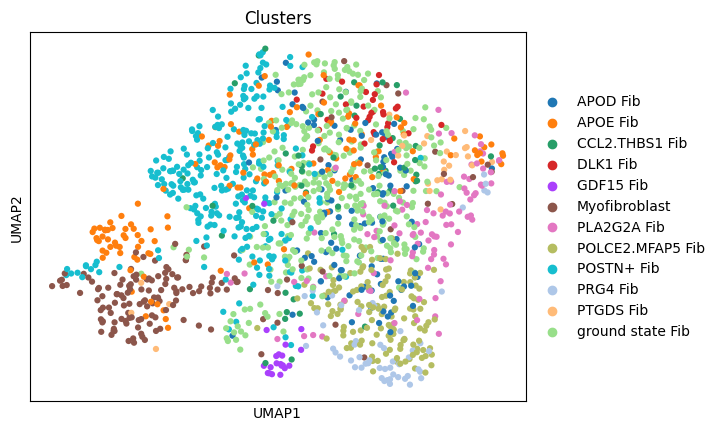

In [26]:
# UMAP

sc.tl.pca(metacell_adata)
sc.pp.neighbors(metacell_adata)
sc.tl.umap(metacell_adata)
sc.pl.umap(metacell_adata, color='main_clustname',title='Clusters')

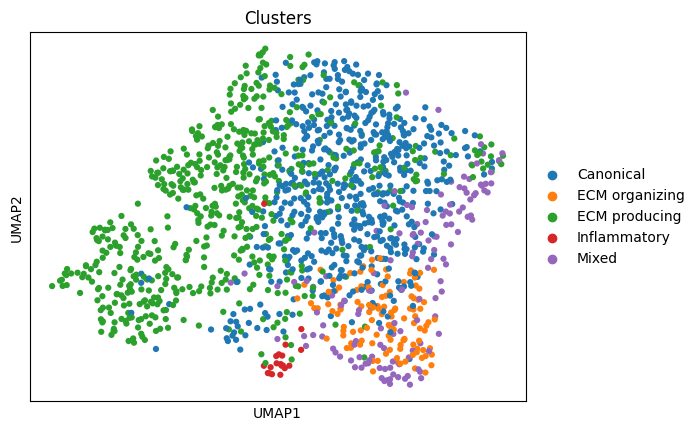

In [27]:
# UMAP

sc.tl.pca(metacell_adata)
sc.pp.neighbors(metacell_adata)
sc.tl.umap(metacell_adata)
sc.pl.umap(metacell_adata, color='main_category',title='Clusters')

In [29]:
codes = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_codes.csv', index_col=0)
codes.columns = codes.columns.astype(int)

total_codes = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_total_fibroblast_bulk_codes.csv', index_col=0)
total_codes.columns = total_codes.columns.astype(int)

comps = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_comps.csv', index_col=0)

In [30]:
fibro_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
fibro_mean_pop.genes.index.name = 'gene_id'

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 5.128173589706421s.
Done.


In [31]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
fibro_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [32]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)

guide_library['masked_active'] = fibro_mean_pop.cells['masked_active']
guide_library['expanded_masked_active'] = fibro_mean_pop.cells['expanded_masked_active']
guide_library['masked_active'].fillna(False, inplace=True)
guide_library['expanded_masked_active'].fillna(False, inplace=True)
guide_library['de_genes'] = fibro_mean_pop.cells['de_genes']

/tmp/ipykernel_277888/1543079379.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  guide_library['masked_active'].fillna(False, inplace=True)
/tmp/ipykernel_277888/1543079379.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_library['masked_active'].fillna(False, inplace=True)
/tmp/ipykernel_277888/15

In [33]:
guide_library['masked_active_rpe1'].fillna(False, inplace=True)
guide_library['masked_active_fibro'].fillna(False, inplace=True)

/tmp/ipykernel_277888/737138646.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  guide_library['masked_active_rpe1'].fillna(False, inplace=True)
/tmp/ipykernel_277888/737138646.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_library['masked_active_rpe1'].fillna(False, inplace=True)
/tmp/ipykernel_2

In [37]:
good_guides = guide_library.query('not seed_driven_fibro and not seed_driven_rpe1 and not bad_seed and cell_count_fibro >= 20 and ((pctl_change_fibro > 5) or (masked_active_fibro or expanded_masked_active or masked_active_rpe1))').index

gene_codes = total_codes.reindex(good_guides).dropna()
gene_codes['gene'] = gene_codes.index.map(lambda x: x.split('_')[0])
gene_codes = gene_codes.set_index('gene', append=True).swaplevel()

In [39]:
# Get strongest guide per gene based on absolute magnitude across all columns
guide_strengths = gene_codes.abs().sum(axis=1)
top_guides = guide_strengths.groupby('gene').nlargest(1) 
# Get index for these top guides
top_guide_idx = top_guides.index.get_level_values(2)
top_guide_idx

Index(['AATF_GTGAAGGGATTGGAGCCGTA', 'ACTL6A_GCAGCAGGACAGAAGGAGTT',
       'ADAR_GAAGGCCTGAGAAGATACGT', 'ADNP_GGGGAGCTCTCGCGAGAACC',
       'ADNP2_GGGGCCTGTGGGAAGTGCCA', 'AEBP2_GTCGAAGCCCGGCAGGGCGT',
       'AFF1_GGAACCCGGTACCGCAGCTC', 'AFF2_GACGTTATCATCCCCGGATC',
       'AHR_GGTGGGGCCCTCAAGGAAGA', 'AHRR_GGGTCCGGCTGTCTCGGGTC',
       ...
       'ZSCAN23_GCTCCGCGAAACAGCGGTTC', 'ZSCAN25_GTGCTGTTCCGAACCCGGCG',
       'ZSCAN26_GGGTCCGCTCACCTGGTCAA', 'ZSCAN29_GGAAGTTCGGCAGCTCAACG',
       'ZSCAN30_GGTGAGGCTTCACAGCGGTC', 'ZSCAN5A_GGAAGCAGGAGTGAAGGAGC',
       'ZSCAN9_GGGGGGTTGAGTCCGAAGCA', 'ZXDA_GGGCGCGGGTTCTGCGGGCT',
       'ZXDB_GCCGGAGCCCAGCGGTCCGC', 'ZXDC_GTCCGAGCCGGACTCTACGC'],
      dtype='object', name='guide_identity', length=1443)

In [40]:
gene_codes_reduced = gene_codes.loc[pd.IndexSlice[:, top_guide_idx], :].droplevel(1)

In [42]:
good_targets = guide_library.loc[good_guides]['target_gene'].unique()
good_targets = np.intersect1d(gene_codes.index.get_level_values(0),metacell_adata.var_names)
gene_codes = gene_codes.loc[good_targets]
gene_codes_reduced = gene_codes_reduced.loc[good_targets]

In [43]:
len(good_targets)

513

In [44]:
from scipy import stats
metacell_adata.X = stats.zscore(metacell_adata.X, axis=0)

In [45]:
# Get gene indices from var_names
genes = ['PI16', 'SPARC', 'COL3A1', 'COL1A1', 'LRRC15', 'COL11A1', 'CTHRC1', 'POSTN']
gene_expr = {}

for gene in genes:
   if gene in metacell_adata.var_names:
       gene_idx = metacell_adata.var_names.get_loc(gene)
       gene_expr[gene] = metacell_adata.X[:, gene_idx]
   else:
       print(f"{gene} not found in data")

# Convert to pandas DataFrame
gene_expr_df = pd.DataFrame(metacell_adata.X, 
                          columns=metacell_adata.var_names,
                          index=metacell_adata.obs.index)

# Filter for target genes
tf_expr = gene_expr_df[good_targets]

# Calculate correlations
correlations = {}
markers = ['PI16', 'SPARC', 'COL3A1', 'COL1A1', 'LRRC15', 'COL11A1', 'CTHRC1', 'POSTN']

for marker in markers:
   marker_expr = gene_expr_df[marker]
   correlations[marker] = tf_expr.corrwith(marker_expr)


In [49]:
sns.set_context('paper')

def plot_and_identify_outliers(series1, series2, size_values=None, labels=None, size_scale=100, context = 'explore', savefig = False):
    """
    Create scatter plot with outlier detection and optional point sizes.
    
    Parameters:
    series1, series2: pandas Series with matching indices
    size_values: pandas Series with matching indices for point sizes (optional)
    labels: list of strings for axis labels
    size_scale: scaling factor for point sizes (default 100)
    """
    def find_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series < lower_bound) | (series > upper_bound)], lower_bound, upper_bound
    
    def find_positive_outliers(series):
        Q3 = series.quantile(0.75)
        IQR = Q3 - series.quantile(0.25)
        upper_bound = Q3 + 1.5 * IQR
        return series[series > upper_bound]
    
    # Process size values
    if size_values is not None:
        # Normalize size values to be between 20 and 200 points
        size_min = size_values.min()
        size_max = size_values.max()
        # Make small points smaller while keeping large ones visible
        normalized_sizes = ((size_values - size_values.min()) / 
                  (size_values.max() - size_values.min())) ** 2 * 300 #+ 3
    else:
        normalized_sizes = pd.Series(50, index=series1.index)  # Default size

    # print(size_values.sort_values())
    # print(normalized_sizes.sort_values())
    
    x_outliers, x_lower, x_upper = find_outliers(series1)
    y_outliers, y_lower, y_upper = find_outliers(series2)
    
    x_pos_outliers = find_positive_outliers(series1)
    y_pos_outliers = find_positive_outliers(series2)
    
    both_pos_outliers = x_pos_outliers.index.intersection(y_pos_outliers.index)
    
    print("Outliers in x-axis:")
    print(x_outliers.index.tolist())
    print("\nOutliers in y-axis:")
    print(y_outliers.index.tolist())
    print("\nPositive outliers in both axes:")
    print(both_pos_outliers.tolist())
    
    if context == 'explore':
        fig, ax = plt.subplots(figsize=(8, 8))
    elif context == 'pub':
        fig, ax = plt.subplots(figsize=(4, 4))
    
    
    # Plot all points in gray with sizes
    ax.scatter(series1, series2, 
              s=normalized_sizes, 
              alpha=0.5, 
              color='gray',
              #marker ='x'
              )
    
    # Plot and annotate x-axis outliers (excluding those in both)
    x_only_outliers = x_outliers[~x_outliers.index.isin(both_pos_outliers)]
    ax.scatter(x_only_outliers, 
              series2.loc[x_only_outliers.index], 
              s=normalized_sizes.loc[x_only_outliers.index],
              color='#D99828', 
              label='X outliers',
              #marker ='x'
              )
    for idx, value in x_only_outliers.items():
        ax.annotate(idx, (value, series2.loc[idx]), xytext=(5, 5), textcoords='offset points')
    
    # Plot and annotate y-axis outliers (excluding those in both)
    y_only_outliers = y_outliers[~y_outliers.index.isin(both_pos_outliers)]
    ax.scatter(series1.loc[y_only_outliers.index], 
              y_only_outliers, 
              s=normalized_sizes.loc[y_only_outliers.index],
              color='#CE6DA1', 
              label='Y outliers',
              #marker ='x'
              )
    for idx, value in y_only_outliers.items():
        ax.annotate(idx, (series1.loc[idx], value), xytext=(5, 5), textcoords='offset points')
    
    # Plot and annotate positive outliers in both axes
    ax.scatter(series1.loc[both_pos_outliers], 
              series2.loc[both_pos_outliers], 
              s=normalized_sizes.loc[both_pos_outliers],
              color='#528FF0', 
              label='Both axes positive outliers',
              #marker ='x'
              )
    for idx in both_pos_outliers:
        ax.annotate(idx, (series1.loc[idx], series2.loc[idx]), xytext=(5, 5), textcoords='offset points')
    
    # Add dashed lines for outlier thresholds
    ax.axhline(y=y_lower, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=y_upper, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=x_lower, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=x_upper, color='gray', linestyle='--', alpha=0.5)
    
    if labels and len(labels) >= 2:
        ax.set_xlabel(f'Correlation to {labels[0]} expression in vivo')
        ax.set_ylabel(f'Program {labels[1]} score in vitro')
    else:
        ax.set_xlabel('Correlation to expression in vivo')
        ax.set_ylabel('Program score in vitro')
    
    #plt.legend()

    if savefig == True:
        plt.savefig(f'{labels[0]}vs{labels[1]}_{context}_cardiacnature2024_invivo_corr.pdf')
    else:
        plt.show()
    
    return x_outliers, y_outliers, pd.Index(both_pos_outliers)

Outliers in x-axis:
['ATF3', 'BACH2', 'BATF', 'BNC2', 'CARHSP1', 'CEBPB', 'CERS6', 'EBF1', 'EBF2', 'EMX2', 'EPAS1', 'ETS2', 'ETV1', 'FOXO1', 'FOXP2', 'FOXS1', 'HAND2', 'HES1', 'HES4', 'HEY2', 'HEYL', 'ID1', 'ID2', 'ID4', 'IRF1', 'IRX3', 'KLF12', 'KLF2', 'KLF3', 'KLF4', 'KLF7', 'MECOM', 'MEF2C', 'MEOX2', 'MSC', 'NFIL3', 'NFKBIZ', 'NOTCH1', 'NR2F2', 'NR4A1', 'NR4A2', 'OSR2', 'PLAGL1', 'PRDM16', 'SMAD3', 'SMAD6', 'SNAI1', 'TBX2', 'TCF21', 'TSC22D1', 'ZEB1', 'ZEB2', 'ZMIZ1']

Outliers in y-axis:
['BCL11A', 'EP300', 'FOSB', 'FOXA1', 'FOXD3', 'HIC1', 'KLF2', 'KLF3', 'KLF4', 'KLF5', 'KLF8', 'NEUROD2', 'SNAI1', 'TBX3', 'ZNF296', 'ZNF439', 'ZNF493', 'ZNF525', 'ZNF587B']

Positive outliers in both axes:
['KLF2', 'KLF4']


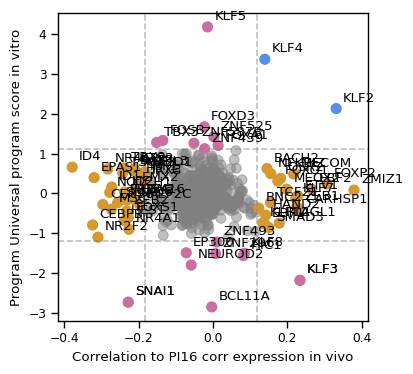

In [50]:
x_outliers, y_outliers, both_outliers = plot_and_identify_outliers(correlations['PI16'], gene_codes_reduced[31],
                                                                   labels=['PI16 corr', 'Universal program'],
                                                                   savefig = True,
                                                                   context = 'pub'
                                                                  )

Outliers in x-axis:
['ATF3', 'ATF5', 'BNC2', 'CARHSP1', 'CEBPB', 'CEBPD', 'FOS', 'FOSL2', 'FOXS1', 'GATA6', 'HES4', 'HEY1', 'HEYL', 'HMGA1', 'IRX3', 'JUNB', 'KLF15', 'KLF2', 'KLF4', 'LRRFIP1', 'MAFB', 'MEOX1', 'NFIL3', 'NR1H3', 'PLAGL1', 'RORA', 'RUNX2', 'SCX', 'ZBTB16', 'ZFP36L1']

Outliers in y-axis:
['AFF1', 'EGR3', 'EPAS1', 'FOXL2', 'KLF5', 'NEUROD2', 'NR2F1', 'PLAG1', 'PLAGL1', 'SALL3', 'SATB1', 'SMAD3', 'STOX2']

Positive outliers in both axes:
['PLAGL1']


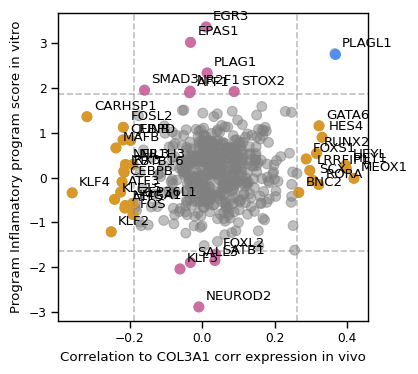

In [51]:
x_outliers, y_outliers, both_outliers = plot_and_identify_outliers(correlations['COL3A1'], gene_codes_reduced[32], 
                                                                   labels=['COL3A1 corr', 'Inflamatory program'],
                                                             savefig = True,
                                                                   context = 'pub')